In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

from RL.arch.ManyToOneMGP_RNN import ManyToOneLMC_MGP_RNN
from RL.database.MIMIC_window import MIMIC_window
import tensorflow as tf
from collections import Counter
import numpy as np
import pickle
from sklearn.metrics import roc_auc_score, average_precision_score

In [10]:
prob_avg_aggregators, prob_std_aggregators, label_aggregators = pickle.load(open('./analyze_all_pats.pkl', 'rb'))

In [15]:
# Make labels as a vector
all_labels = []
all_probs = []

for k in label_aggregators:
    for val in label_aggregators[k]:
        all_labels.append(val[0])
    
    for prob in prob_avg_aggregators[k]:
        all_probs.append(prob)

In [17]:
print('auroc:', roc_auc_score(all_labels, all_probs))
print('aupr:', average_precision_score(all_labels, all_probs))

auroc: 0.856178957073
aupr: 0.619985924238


In [4]:
keys = np.array(list(prob_avg_aggregators.keys()))
keys.sort()

values = np.array([np.mean(prob_avg_aggregators[k]) for k in keys])
std_values = np.array([np.std(prob_avg_aggregators[k]) for k in keys])

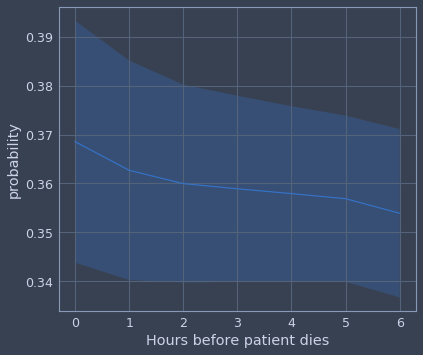

In [7]:
plt.plot(keys, values)
plt.xlabel('Hours before patient dies')
plt.ylabel('probability')
plt.fill_between(keys, values - std_values, values + std_values, alpha=0.3)
# plt.xlim(0, 48)

(0, 48)

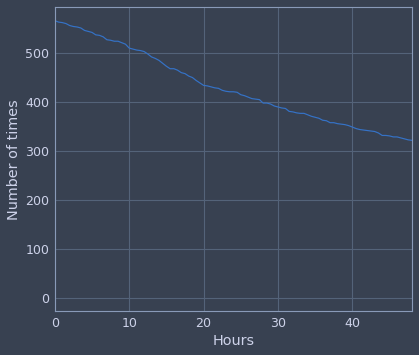

In [9]:
plt.plot(keys * 0.5, [len(prob_avg_aggregators[k]) for k in keys])
plt.ylabel('Number of times')
plt.xlabel('Hours')
plt.xlim(0, 48)

## Calculate this running window-based aupr
- Use 48 hours
- Use first 6 hours (including) as 1 and the rest as 0

In [23]:
all_arr = [prob_avg_aggregators[k] for k in positive_keys]


In [38]:

def get_probs_by_keys(keys):
    all_arr = [prob_avg_aggregators[k] for k in keys]
    tmp = []
    for k in all_arr:
        tmp += k
    return tmp
# Take keys from 0 to 12 (13 points) as 1
positive_keys = range(0, 49)
positivie_probs = get_probs_by_keys(positive_keys)

positive_labels = [1 for _ in positivie_probs]

negative_keys = range(49, 2000)
neg_probs = get_probs_by_keys(negative_keys)
neg_labels = [0 for _ in neg_probs]

all_probs = np.array(positivie_probs + neg_probs)
all_labels = np.array(positive_labels + neg_labels)

print('auroc:', roc_auc_score(all_labels, all_probs))
print('aupr:', average_precision_score(all_labels, all_probs))

auroc: 0.69689388405
aupr: 0.436469338324


(0, 10)

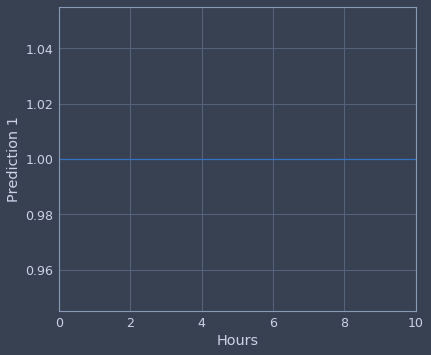

In [40]:
threshold = 0.3

num_correct = []
for k in keys:
    pred_1 = np.mean(np.array(prob_avg_aggregators[k]) > threshold)
    num_correct.append(pred_1)
    
plt.plot(keys * 0.5, num_correct)
plt.ylabel('Prediction 1')
plt.xlabel('Hours')
plt.xlim(0, 10)

In [2]:
params = {"data_dir": "../data/my-mortality/", "database_name": "mingie_34features.pkl", 
           "num_gp_samples_limit": 300, "data_interval": 0.5, "before_end": 0., 
           "num_hours_warmup": 6, "min_measurements_in_warmup": 10, "num_hours_pred": 6, 
           "num_X_pred": 25, "val_ratio": 0.1, "include_before_death": None, "verbose": False}
database = MIMIC_window(**params)

In [3]:
the_trained_dir = '../models/0510--mimic-nh16-nl1-c1e-04-pos1-npred6-n_mc_15-' \
    'MIMIC_window-mingie_34features-ManyToOneLMC_MGP_RNN'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    mgp_rnn = ManyToOneLMC_MGP_RNN.load_saved_mgp_rnn(sess, the_trained_dir)
    test_loader = database.create_test_loader(batch_size=32)
    
    total_batches = next(test_loader)
    
    aggregators = Counter()
    total_aggregators = Counter()
    for the_batch, obs_dict in enumerate(test_loader):
        feed_dict = mgp_rnn.create_feed_dict_by_sparse_arr(**obs_dict)
        O_pred, probs = sess.run([mgp_rnn.O_pred, mgp_rnn.probs], feed_dict)

        labels = obs_dict['labels']
        
        if the_batch % 20 == 19:
            print('[%d/%d]' % (the_batch, total_batches))

        for step, total_step, correct in zip(obs_dict['the_steps'], obs_dict['total_steps'],
                                             O_pred == labels):
            the_idx = total_step - 1 - step

            aggregators[the_idx] += int(correct)
            total_aggregators[the_idx] += 1

Find model.log ... The best model idx is 23
INFO:tensorflow:Restoring parameters from ../models/0510--mimic-nh16-nl1-c1e-04-pos1-npred6-n_mc_15-MIMIC_window-mingie_34features-ManyToOneLMC_MGP_RNN/model-23
[19/606]
[39/606]
[59/606]
[79/606]
[99/606]
[119/606]
[139/606]
[159/606]
[179/606]
[199/606]
[219/606]
[239/606]
[259/606]
[279/606]
[299/606]
[319/606]
[339/606]
[359/606]
[379/606]
[399/606]
[419/606]
[439/606]
[459/606]
[479/606]
[499/606]
[519/606]
[539/606]
[559/606]
[579/606]
[599/606]
[619/606]
[639/606]
[659/606]
[679/606]
[699/606]
[719/606]
[739/606]
[759/606]
[779/606]
[799/606]
[819/606]
[839/606]
[859/606]
[879/606]
[899/606]
[919/606]
[939/606]
[959/606]
[979/606]
[999/606]
[1019/606]
[1039/606]
[1059/606]
[1079/606]
[1099/606]
[1119/606]
[1139/606]
[1159/606]
[1179/606]
[1199/606]
[1219/606]
[1239/606]
[1259/606]
[1279/606]
[1299/606]
[1319/606]
[1339/606]
[1359/606]
[1379/606]
[1399/606]
[1419/606]
[1439/606]
[1459/606]
[1479/606]
[1499/606]
[1519/606]
[1539/606]
[15

KeyboardInterrupt: 

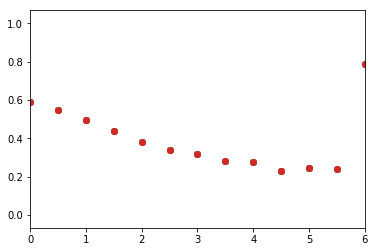

In [40]:
import matplotlib.pyplot as plt

keys = np.array(list(aggregators.keys()))
keys.sort()
values = []

for k in keys:
    correct = aggregators[k]
    total_num = total_aggregators[k]
    values.append(correct / total_num)

plt.scatter(keys * 0.5, values)
plt.xlim(0, 6)
plt.show()

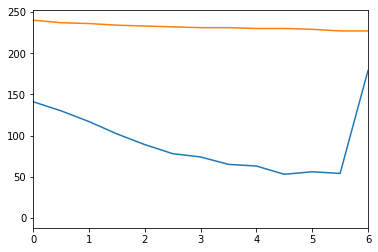

In [35]:
plt.plot(keys * 0.5, [aggregators[k] for k in keys])
plt.plot(keys * 0.5, [total_aggregators[k] for k in keys])
plt.xlim(0, 6)
plt.show()